In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/iss

/content/gdrive/MyDrive/iss


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
import matplotlib.pyplot as plt
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [5]:
SEED = 2021

In [6]:
def rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))

In [7]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    return X_train, X_test, y_train, y_test

In [8]:
def plot_target(y_train, y_test, label_1='y_train', label_2='y_test'):
    fig, ax = plt.subplots()
    pd.DataFrame(y_train).hist(ax=ax, bins=100)
    y_test.hist(ax=ax, bins=100)
    ax.set_yscale('log')
    ax.legend([label_1, label_2])

In [9]:
df = pd.read_csv("https://storage.yandexcloud.net/nlp-dataset-bucket-1/toloka-vk-proceedings-2020/toloka-vk-raw-unprocessed.tsv", sep='\t',
                 names=['INPUT:text', 'OUTPUT:disgust_rage', 'OUTPUT:fear_surprise', 'OUTPUT:shame_excitement', 'OUTPUT:enjoyment_distress'],
                 index_col=False, header=0)
df = df.dropna(how='all')
df.head()

,INPUT:text,OUTPUT:disgust_rage,OUTPUT:fear_surprise,OUTPUT:shame_excitement,OUTPUT:enjoyment_distress
0,"Приехала в свой родной город на выходные, от з...",2.0,3.0,0.0,2.0
2,У моей мамы два с половиной года назад отказал...,0.0,-4.0,0.0,5.0
4,Два года назад племянника моего мужа сбила маш...,5.0,-2.0,0.0,5.0
6,"Год без секса, но больше всего скучаю не по фи...",0.0,0.0,4.0,1.0
8,На днях узнала что беременна . Мой жених уходи...,0.0,-5.0,-3.0,3.0


In [10]:
input_col = 'INPUT:text'
outpul_cols = ['OUTPUT:disgust_rage', 'OUTPUT:fear_surprise', 'OUTPUT:shame_excitement', 'OUTPUT:enjoyment_distress']

In [11]:
y = df['OUTPUT:disgust_rage'].values
X = df[input_col]

X_train, X_test, y_train, y_test = split_data(X, y)

X_train = X_train.values
X_test = X_test.values

In [12]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [22]:
def objective(space):
    model = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    n_estimators=int(space['n_estimators']),
                    max_depth=int(space['max_depth']),
                    eta=space['eta'],
                    gamma = space['gamma'],
                    colsample_bytree=space['colsample_bytree'],
                    min_child_weight = space['min_child_weight'],
                    subsample = space['subsample'],
                    random_state=SEED
                    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(X_train, y_train,
              eval_set=evaluation,
              early_stopping_rounds=10,
              verbose=False)

    cv_scores = cross_val_score(estimator=model,
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=make_scorer(rmse))
    score = cv_scores.mean()
    

    print("Cross validation score:", score)
    return {'loss': score, 'status': STATUS_OK }

In [14]:
def run_hyperparams_search():

  space={
       'max_depth': hp.quniform('max_depth', 5, 15, 1),
       'gamma': hp.quniform('gamma', 0, 0.50, 0.01),
       'eta': hp.quniform('eta', 0.01, 0.5, 0.01),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 100, 400, 1),
       'subsample': hp.quniform('subsample', 0.1, 1, 0.01),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
  }

  trials = Trials()

  best_hyperparams = fmin(fn=objective,
                          space=space,
                          algo=tpe.suggest,
                          max_evals=50,
                          trials=trials)
  return best_hyperparams

In [15]:
def fit_model_from_best(best_params):
    model = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    n_estimators=int(best_params['n_estimators']),
                    max_depth=int(best_params['max_depth']),
                    eta=best_params['eta'],
                    gamma = best_params['gamma'],
                    colsample_bytree=best_params['colsample_bytree'],
                    min_child_weight = best_params['min_child_weight'],
                    subsample = best_params['subsample'],
                    random_state=SEED
                    )

    model.fit(X_train, y_train)

    cv_scores = cross_val_score(estimator=model,
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=make_scorer(rmse))
    score = cv_scores.mean()
    print("Cross validation score:", score)
    return model

In [23]:
best_hyperparams = run_hyperparams_search()

Cross validation score:
2.2992910643794637
Cross validation score:
2.2852716123746313
Cross validation score:
2.2887427592676386
Cross validation score:
2.3633535912348975
Cross validation score:
2.3673541320178595
Cross validation score:
2.2942056760656055
Cross validation score:
2.3050576255808695
Cross validation score:
2.3576538665230515
Cross validation score:
2.3373619736655167
Cross validation score:
2.322170683799331
Cross validation score:
2.3100839717968187
Cross validation score:
2.444805736316396
Cross validation score:
2.3472123752615053
Cross validation score:
2.565009296417024
Cross validation score:
2.6763614306453163
Cross validation score:
2.4581667961779643
Cross validation score:
2.360020710982542
Cross validation score:
2.3035248518819778
Cross validation score:
2.3001226210070014
Cross validation score:
2.3766129353585264
Cross validation score:
2.257376225865715
Cross validation score:
2.279609420196384
Cross validation score:
2.2529014657333106
Cross validation 

In [24]:
best_hyperparams

{'colsample_bytree': 0.61,
 'eta': 0.04,
 'gamma': 0.13,
 'max_depth': 5.0,
 'min_child_weight': 3.0,
 'n_estimators': 106.0,
 'subsample': 0.86}

In [25]:
%%time
model = fit_model_from_best(best_hyperparams)

Cross validation score: 2.2520294428122933
CPU times: user 29.2 s, sys: 67.9 ms, total: 29.2 s
Wall time: 29.2 s


In [34]:
preds = model.predict(X_test)
print('rmse value: ', rmse(preds, y_test))

rmse value:  2.2640847507642787


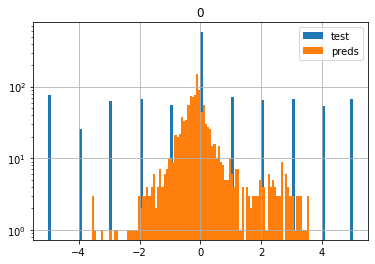

In [31]:
plot_target(y_test, pd.Series(preds), 'test', 'preds')